In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.util.systems import LowRankRNN
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import assess_constraints, pairplot
import warnings
import scipy
import time
warnings.filterwarnings("ignore")
from dsn.util.tf_DMFT_solvers import rank1_spont_chaotic_solve


/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
sample_str = 'grid';
num_params = 4
if (sample_str == 'grid'):
    # create test parameter grid
    bound = 4.0
    start = 0.0;
    stop = bound;
    res = 0.5
    eps = .001*res;
    vals = np.arange(start, stop+eps, res);
    num_pts = vals.shape[0];

    total_pts = num_pts**num_params;
    params = np.zeros((total_pts,num_params));
    ind = 0;
    for i in range(num_pts):
        g = vals[i];
        for j in range(num_pts):
            Mm = vals[j];
            for k in range(num_pts):
                Mn = vals[k];
                for l in range(num_pts):
                    Sm = vals[l];
                    params[ind, :] = np.array([g, Mm, Mn, Sm])
                    ind += 1;
                        

In [12]:
print(total_pts)

6561


In [13]:

DTYPE = tf.float64
mu_init = 50.0 * tf.ones((total_pts,), dtype=DTYPE)
delta_0_init = 55.0 * tf.ones((total_pts,), dtype=DTYPE)
delta_inf_init = 45.0 * tf.ones((total_pts,), dtype=DTYPE)
        
num_params = 4
K = 1;
Z = tf.placeholder(dtype=tf.float64, shape=(None, num_params));

solve_its = 25
solve_eps = 0.5

mu, delta_0, delta_inf = rank1_spont_chaotic_solve(
                    mu_init,
                    delta_0_init,
                    delta_inf_init,
                    Z[:,0],
                    Z[:,1],
                    Z[:,2],
                    Z[:,3],
                    solve_its,
                    solve_eps,
                    gauss_quad_pts=50,
                    db=False,
                )



sess = tf.Session()

In [14]:
print(mu_init, Z[:,0])

Tensor("mul_2803:0", shape=(6561,), dtype=float64) Tensor("strided_slice_1140:0", shape=(?,), dtype=float64)


In [15]:
_mu, _delta_0, _delta_inf = sess.run([mu, delta_0, delta_inf], {Z:params});
_Z = params

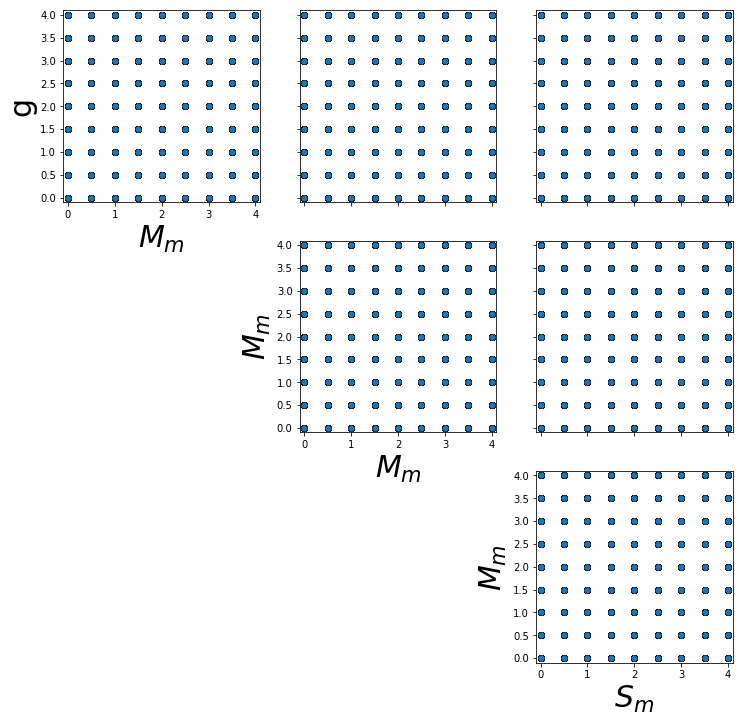

In [16]:
pfname = 'images/LRRNN_spont_chaotic_explore_Z.png'

lims = [-.1, 4.1]
jitter = np.random.normal(0.0, 0.00, _Z.shape)
_Z_plot = (_Z + jitter)

fig = pairplot(_Z_plot, range(4), ['g', r'$M_m$', r'$M_m$', r'$S_m$'], origin=False, \
                       c=None, c_label=None, cmap=None, \
                       xlims=lims, ylims=lims, fontsize=30, \
                       figsize=(12,12), pfname=pfname)



In [17]:
_delta_T = _delta_0 - _delta_inf
T_x = np.stack([_mu, _delta_inf, _delta_T], axis=1)

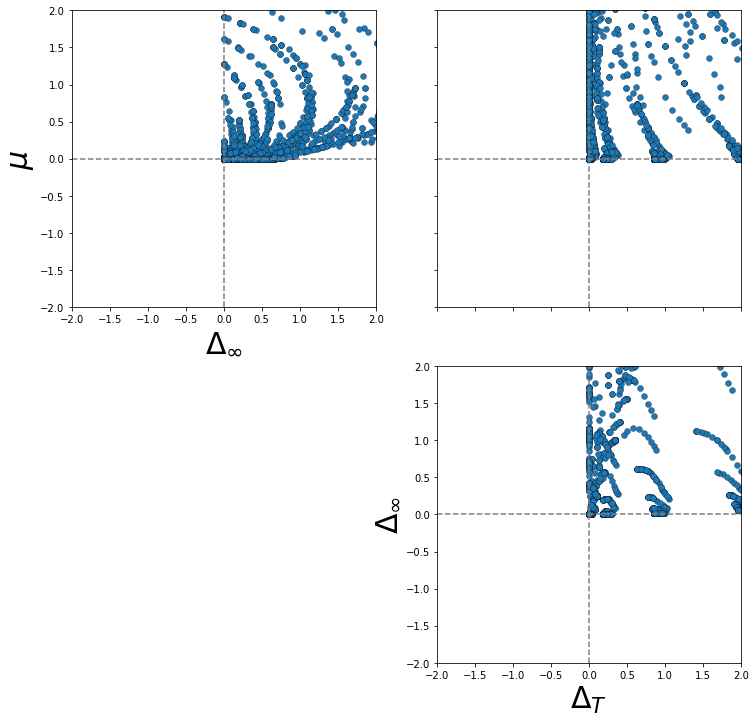

In [19]:
pfname = 'images/LRRNN_explore_T_x.png'
axlim = 2
xlims = [-axlim, axlim]
ylims = [-axlim, axlim]

fig = pairplot(T_x, range(3), [r'$\mu$', r'$\Delta_\infty$', r'$\Delta_T$'], origin=True, \
                   c=None, c_label=None, cmap=None, \
                   xlims=xlims, ylims=ylims, fontsize=30, \
                   figsize=(12,12), pfname=pfname)



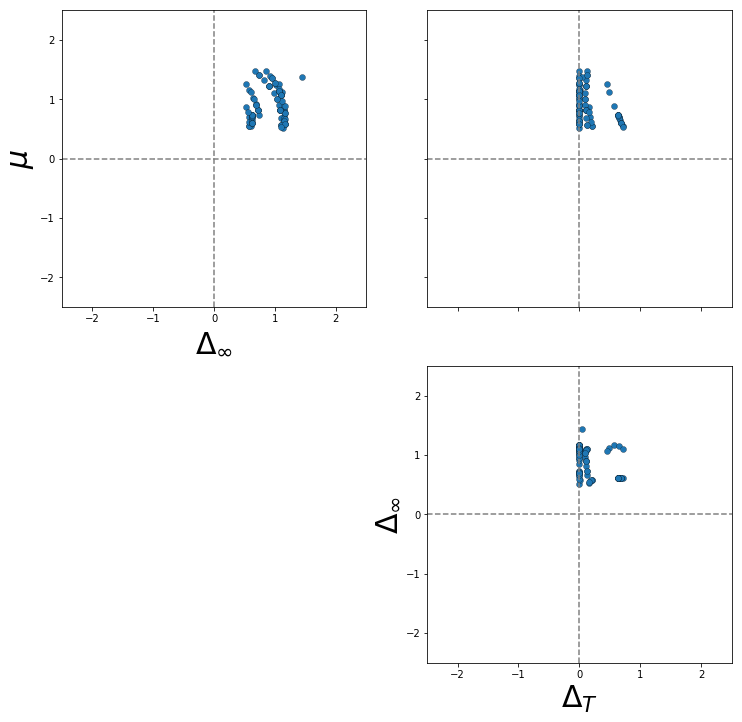

In [11]:
pfname = 'images/LRRNN_grid_search_T_x_thresh.png'

axlim = 2.5
xlims = [-axlim, axlim]
ylims = [-axlim, axlim]

delta_T_inc = np.logical_and(0.0 < _T_x[0,:,2], _T_x[0,:,2] < 1.0);
delta_inf_inc = np.logical_and(0.5 < _T_x[0,:,1], _T_x[0,:,1] < 1.5);
mu_inc = np.logical_and(0.5 < _T_x[0,:,0], _T_x[0,:,0] < 1.5);
delta_inf_inc_delta_T_inc = np.logical_and(delta_T_inc, delta_inf_inc);
inds =  np.logical_and(delta_inf_inc_delta_T_inc, mu_inc);

fig = pairplot(_T_x[0, inds, :], range(3), system.T_x_labels, origin=True, \
                   c=None, c_label=None, cmap=None, \
                   xlims=xlims, ylims=ylims, fontsize=30, \
                   figsize=(12,12), pfname=pfname)

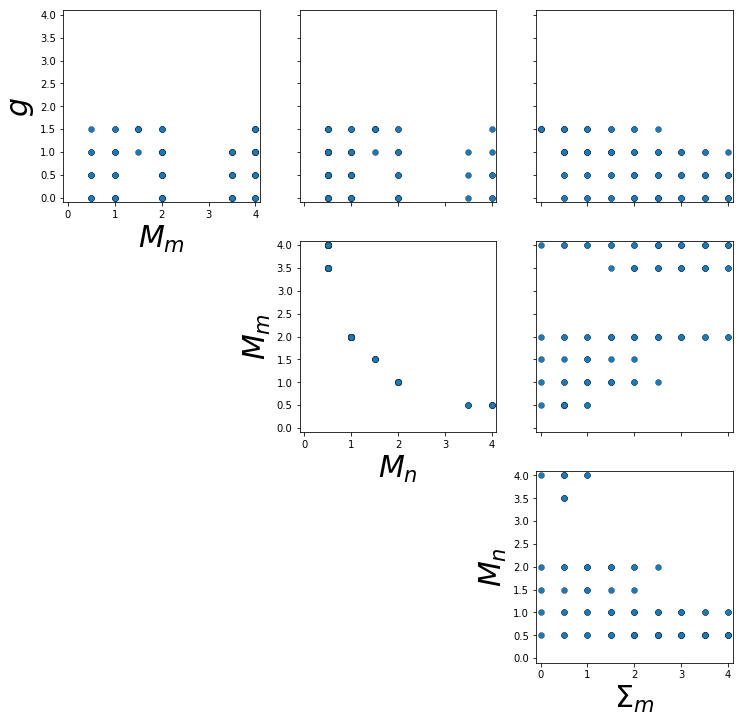

In [12]:
pfname = 'images/LRRNN_grid_search_Z_tresh.png'
_Z_filt = _Z[0,inds, :]

fig = pairplot(_Z_filt, range(4), system.z_labels, origin=False, \
               c=None, c_label=None, cmap=None, \
               xlims=lims, ylims=lims, fontsize=30, \
               figsize=(12,12), pfname=pfname)

85
(1, 6561, 4)
0.9160783645270059 0.27204162404702265


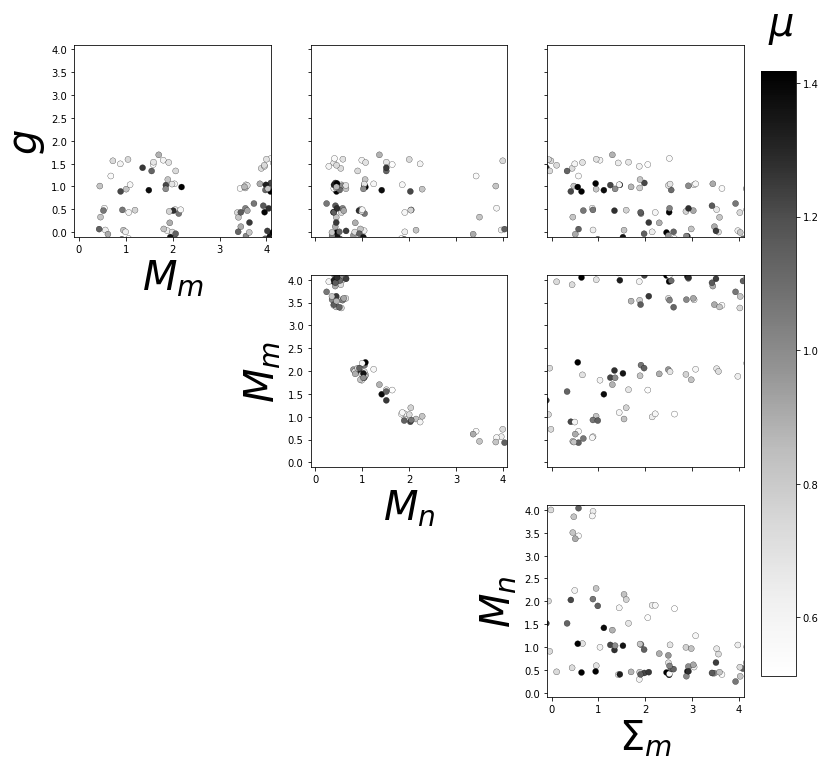

0.9046139795849473 0.2341953991857025


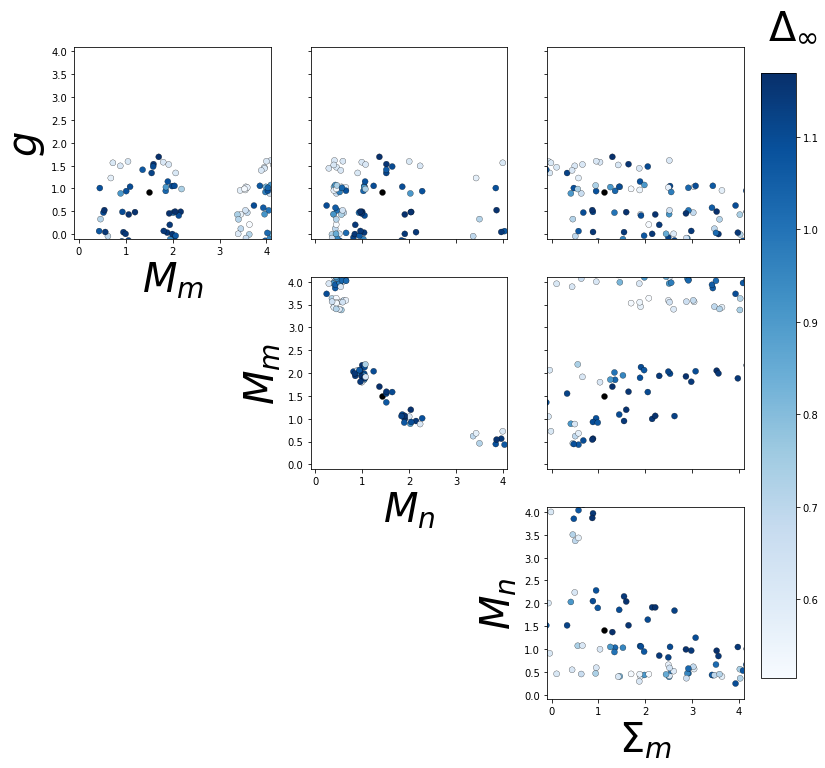

0.16339077951957282 0.24353023746887204


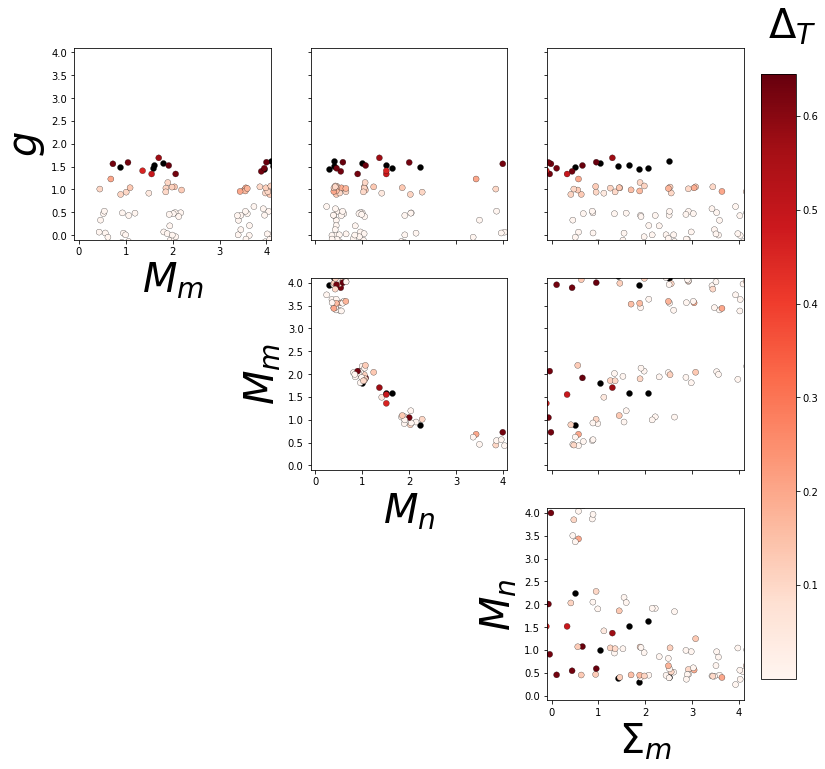

In [13]:
pfname = 'images/Z_S_inc_V_same.png'

mu_inc = np.logical_and(0.5 < _T_x[0,:,0], _T_x[0,:,0] < 1.5);
inds =  np.logical_and(delta_inf_inc_delta_T_inc, mu_inc);

lims = [-.1, 4.1]
print(np.sum(inds))
print(_Z.shape)
_Z_filt = _Z[0,inds, :]
jitter = np.random.normal(0.0, 0.1, _Z_filt.shape)
_Z_filt = _Z_filt + jitter
for color_ind in range(3):
    fig = pairplot(_Z_filt, range(4), system.z_labels, origin=False, \
                       c=_T_x[0,inds,color_ind], c_label=system.T_x_labels[color_ind], cmap=cmaps[color_ind], \
                       xlims=lims, ylims=lims, fontsize=40, \
                       figsize=(12,12), pfname=pfname)